In [536]:
import json
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # matplotlib is not installed automatically
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [564]:
network_name = 'California'

home_dir = r"G:\Araki\SMSigxSMAP"
input_path = r"1_data"
appeears_path = r"APPEEARS_subsetting"
SMAPL3_path = r"SPL3SMP_E"
SMAPL4_path = r"SPL4SMGP"
SMAPL4_grid_path = r"SMAPL4SMGP_EASEreference"
MODIS_path = r"MOD15A2H"
PET_path = r"PET"

output_path = r"3_data_out\exp_plots"

## Read and process data

### Request json

In [565]:
file_path = os.path.join(home_dir, input_path, appeears_path, network_name, f'{network_name}-request.json')
with open(file_path, 'r') as infile:
    request_content = json.load(infile)

coordinates = request_content['params']['coordinates']

coordinate = 0
target_lat = coordinates[coordinate]['latitude']
target_lon = coordinates[coordinate]['longitude']
target_station = coordinates[coordinate]['category']
print(f'Currently processing station: {target_station}')

output_path2 = os.path.join(home_dir, output_path, target_station)
if not os.path.exists(output_path2):
    os.makedirs(output_path2)

Currently processing station: Central_valley


### SMAP L3

In [539]:
file_path = os.path.join(input_path, appeears_path, network_name, f'{network_name}-SPL3SMP-E-005-results.csv')
SMAPL3_pt_sample = pd.read_csv(file_path)
SMAPL3_pt_sample = SMAPL3_pt_sample[(SMAPL3_pt_sample['Latitude'] == target_lat) & (SMAPL3_pt_sample['Longitude'] == target_lon)].copy()

df_ts_smap_am = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag']].copy()
df_ts_smap_am['Date'] = pd.to_datetime(df_ts_smap_am['Date'])
df_ts_smap_am.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_am[(df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 0.0) & (df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag'] != 8.0)].index
df_ts_smap_am.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_am_daily = df_ts_smap_am['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture'].resample('D', axis=0).mean()

df_ts_smap_pm = SMAPL3_pt_sample[['Date', 'SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm']].copy()
df_ts_smap_pm['Date'] = pd.to_datetime(df_ts_smap_pm['Date'])
df_ts_smap_pm.set_index('Date', inplace=True)
bad_data_idx_smap = df_ts_smap_pm[(df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 0.0) & (df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm'] != 8.0)].index
df_ts_smap_pm.drop(bad_data_idx_smap, inplace=True)
df_ts_smap_pm_daily = df_ts_smap_pm['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm'].resample('D', axis=0).mean()

df_ts_sync = pd.merge(df_ts_smap_am_daily, df_ts_smap_pm_daily, how='inner', left_index=True, right_index=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync[['SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture','SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm']].mean(axis=1, skipna=True)
df_ts_sync['soil_moisture_smapL3'] = df_ts_sync['soil_moisture_smapL3'].resample('D', axis=0).mean()

### SMAPL4

In [540]:
file_path = os.path.join(input_path, appeears_path, network_name, f'{network_name}-SPL4SMGP-006-results.csv')
SMAPL4_pt_sample = pd.read_csv(file_path)
SMAPL4_pt_sample = SMAPL4_pt_sample[(SMAPL4_pt_sample['Latitude'] == target_lat) & (SMAPL4_pt_sample['Longitude'] == target_lon)].copy()
# print(SMAPL4_pt_sample.columns)

# SMAPL4_pt_sample[['SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0', 
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_1',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_2',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_3',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_4',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_5',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_6',
#                   'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_7']].plot()

# ? Where is data converted to daily from hourly? 

df_ts_smap_precip = SMAPL4_pt_sample[['Date', 'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0']].copy()
df_ts_smap_precip = df_ts_smap_precip.rename({'SPL4SMGP_006_Geophysical_Data_precipitation_total_surface_flux_0': 'precip'}, axis='columns')
df_ts_smap_precip['Date'] = pd.to_datetime(df_ts_smap_precip['Date'])
df_ts_smap_precip.set_index('Date', inplace=True)
df_ts_smap_precip

,precip
Date,
2015-03-31,0.000000
2015-04-01,0.000000
2015-04-02,0.000000
2015-04-03,0.000000
2015-04-04,0.000000
...,...
2022-03-26,0.000000
2022-03-27,0.000000
2022-03-28,0.000000


Convert precipitation from kg/m2/s to mm/day -> 1 kg/m2/s = 86400 mm/day

In [541]:
df_ts_smap_precip = df_ts_smap_precip * 86400

In [542]:
df_ts_sync = pd.merge(df_ts_sync, df_ts_smap_precip, how='inner', left_index=True, right_index=True)

noprecip = df_ts_smap_precip['precip'] < 0.00002
df_ts_sync['noprecip'] = noprecip

df_ts_sync.head()

,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_AM_soil_moisture,SPL3SMP_E_005_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,soil_moisture_smapL3,precip,noprecip
Date,,,,,
2015-04-03,0.080593,NaN,0.080593,0.0,True
2015-04-04,NaN,0.052842,0.052842,0.0,True
2015-04-05,0.073338,NaN,0.073338,0.0,True
2015-04-06,0.082093,NaN,0.082093,0.0,True
2015-04-07,NaN,0.050903,0.050903,0.0,True


<Axes: xlabel='Date'>

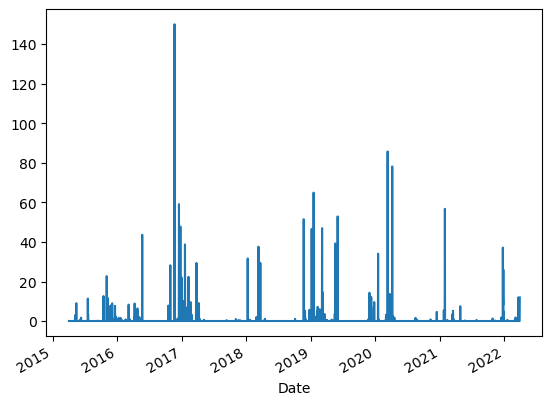

In [543]:
df_ts_sync['precip'].plot()

### PET

Get the point-sampled PET data beforehand by running '0_code\singerPET_create_datarods_v3.py'

In [544]:
file_path = os.path.join(input_path, PET_path, target_station)
file_list = os.listdir(file_path)

print(file_list)
PET = pd.read_csv(os.path.join(file_path, file_list[0]), header=None)
day_num = PET.index.to_numpy()
year = file_list[0][-8:-4]
PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
PET.set_index('Date', inplace=True)

for i, file in enumerate(file_list):
    PET = pd.read_csv(os.path.join(file_path, file), header=None)
    year = file[-8:-4]
    PET['Date'] = pd.to_datetime(PET.index, unit='D', origin=pd.Timestamp(year))
    PET.set_index('Date', inplace=True)
    if i==0:
        ds_PET = PET
    else:
        ds_PET = pd.concat([ds_PET, PET])
ds_PET = ds_PET.sort_index()
ds_PET = ds_PET.rename(columns = {0:'PET'})
ds_PET

['dPET_2015.txt', 'dPET_2016.txt', 'dPET_2017.txt', 'dPET_2018.txt', 'dPET_2019.txt', 'dPET_2020.txt', 'dPET_2021.txt']


,PET
Date,
2015-01-01,1.20622
2015-01-02,1.32404
2015-01-03,1.30129
2015-01-04,1.39553
2015-01-05,1.54896
...,...
2021-12-27,0.65487
2021-12-28,0.54032
2021-12-29,0.35751


In [545]:
ds_synced = pd.merge(df_ts_sync[['soil_moisture_smapL3', 'precip']], ds_PET, how='inner', left_index=True, right_index=True)
ds_synced = ds_synced.rename({'soil_moisture_smapL3': 'soil_moisture_daily'}, axis='columns')
ds_synced

,soil_moisture_daily,precip,PET
Date,,,
2015-04-03,0.080593,0.00000,4.26590
2015-04-04,0.052842,0.00000,4.10291
2015-04-05,0.073338,0.00000,3.96359
2015-04-06,0.082093,0.00000,3.65490
2015-04-07,0.050903,0.00000,2.23610
...,...,...,...
2021-12-27,NaN,0.00000,0.65487
2021-12-28,NaN,4.76064,0.54032
2021-12-29,NaN,0.06912,0.35751


## Calculate dSdt

In [546]:
# Thresholds
lower_quantile_thresh = 0.25
upper_quantile_thresh = 0.75
precip_thresh = 0.00002

In [547]:
precip_mask = ds_synced['precip'].where(ds_synced['precip'] < precip_thresh)
no_sm_record_but_precip_present = ds_synced['precip'].where((precip_mask.isnull()) & (ds_synced['soil_moisture_daily'].isnull()))
ds_synced['sm_for_dS_calc'] = ds_synced['soil_moisture_daily'].where(no_sm_record_but_precip_present.isnull(), 9999)

In [548]:
# Calculate dS
ds_synced['dS'] = ds_synced['sm_for_dS_calc'].bfill(limit=5).diff().where(ds_synced['sm_for_dS_calc'].notnull().shift(periods=+1))

# Drop the dS where  (precipitation is present) && (soil moisture record does not exist)
ds_synced['dS'] = ds_synced['dS'].where((ds_synced['dS'] > -1) & (ds_synced['dS'] < 1))

# Calculate dt
non_nulls = ds_synced['sm_for_dS_calc'].isnull().cumsum()
nan_length = non_nulls.where(ds_synced['sm_for_dS_calc'].notnull()).bfill()+1 - non_nulls +1
ds_synced['dt'] = nan_length.where(ds_synced['sm_for_dS_calc'].isnull()).fillna(1)

# Calculate dS/dt
ds_synced['dSdt'] = ds_synced['dS']/ds_synced['dt']
ds_synced['dSdt'] = ds_synced['dSdt'].shift(periods=-1)


In [549]:
# Mask where precipitation is on the day 1 of soil moisture measruement
# ds_synced['dSdt'] = ds_synced['dSdt'].where(precip_mask.notnull())

In [550]:
ds_synced.head()

,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt
Date,,,,,,,
2015-04-03,0.080593,0.0,4.26590,0.080593,NaN,1.0,-0.027751
2015-04-04,0.052842,0.0,4.10291,0.052842,-0.027751,1.0,0.020496
2015-04-05,0.073338,0.0,3.96359,0.073338,0.020496,1.0,0.008755
2015-04-06,0.082093,0.0,3.65490,0.082093,0.008755,1.0,-0.031190
2015-04-07,0.050903,0.0,2.23610,0.050903,-0.031190,1.0,0.142930


## Detect significant peak

Adapt https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2017GL072819


- Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
- To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08). 
- Of the remaining drydowns, only those that contained more than three SMAP observations were retained.

In [552]:
dSdt_thresh = (ds_synced.soil_moisture_daily.max() - ds_synced.soil_moisture_daily.min()) * 0.05
# dSdt_thresh = 0.03
target_rmsd = 0.08
dSdt_thresh

0.01910189

In [553]:
ds_synced.head(15)

,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt
Date,,,,,,,
2015-04-03,0.080593,0.0,4.26590,0.080593,NaN,1.0,-0.027751
2015-04-04,0.052842,0.0,4.10291,0.052842,-0.027751,1.0,0.020496
2015-04-05,0.073338,0.0,3.96359,0.073338,0.020496,1.0,0.008755
2015-04-06,0.082093,0.0,3.65490,0.082093,0.008755,1.0,-0.031190
2015-04-07,0.050903,0.0,2.23610,0.050903,-0.031190,1.0,0.142930
2015-04-08,0.193834,0.0,3.47952,0.193834,0.142930,1.0,-0.066909
2015-04-09,0.126924,0.0,2.94221,0.126924,-0.066909,1.0,-0.021711
2015-04-10,0.105213,0.0,3.96109,0.105213,-0.021711,1.0,-0.004836
2015-04-11,0.100377,0.0,4.97817,0.100377,-0.004836,1.0,-0.030174


In [554]:
negative_increments = ds_synced.dSdt < 0
positive_increments = ds_synced.dSdt > target_rmsd
# positive_increments = ds_synced.dS.ffill() > target_rmsd
# Negative dSdt preceded with positive dSdt
ds_synced['event_start'] = negative_increments.values & np.concatenate(([False], positive_increments[:-1]))
ds_synced['event_start'][ds_synced['event_start']].index
# drydown_indices = ds_synced.index[negative_increments & pd.Series(np.concatenate(([False], positive_increments[:-1])), index=ds_synced.index)]
# drydown_indices
# sum(negative_increments.values & np.concatenate(([False], positive_increments[:-1])))

DatetimeIndex(['2015-04-08', '2015-07-19', '2015-11-10', '2015-12-14',
               '2016-03-06', '2016-03-12', '2016-04-28', '2016-05-06',
               '2017-02-18', '2017-03-25', '2018-01-05', '2018-01-20',
               '2018-02-27', '2018-10-04', '2018-11-29', '2018-12-17',
               '2019-02-01', '2019-02-09', '2019-04-16', '2019-05-16',
               '2019-05-19', '2019-05-27', '2019-11-27', '2019-12-23',
               '2020-11-07', '2021-03-10', '2021-03-15', '2021-03-20',
               '2021-12-10'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [555]:
# # iterate through each row to find event end
# precip_thresh = 2
# event_end = np.zeros(ds_synced.shape[0], dtype=bool)
# ds_synced['dS'] = ds_synced['dS'].shift(-1)
# for i in range(1, ds_synced.shape[0]):
#     if ds_synced['event_start'][i]:
#         start_index = i
#         for j in range(i+1, ds_synced.shape[0]):
#             if np.isnan(ds_synced['dS'][j]):
#                 continue
#             if ds_synced['dS'][j] >= dSdt_thresh or ds_synced['precip'][j] > precip_thresh:
#                 event_end[j] = True
#                 break

# # create a new column for event_end
# ds_synced['event_end'] = event_end
# iterate through each row to find event end
precip_thresh = 2
event_end = np.zeros(ds_synced.shape[0], dtype=bool)
# ds_synced['dS'] = ds_synced['dS'].shift(-1)
for i in range(1, ds_synced.shape[0]):
    if ds_synced['event_start'][i]:
        start_index = i
        for j in range(i+1, ds_synced.shape[0]):
            if np.isnan(ds_synced['dS'][j]):
                None
            if ds_synced['dS'][j] >= dSdt_thresh or ds_synced['precip'][j] > precip_thresh:
                event_end[j] = True
                break

# create a new column for event_end
ds_synced['event_end'] = event_end
ds_synced['event_end'] = ds_synced['event_end'].shift(-1)
ds_synced = ds_synced[:-1]

In [556]:
ds_synced['event_start'][ds_synced['event_start']].index

DatetimeIndex(['2015-04-08', '2015-07-19', '2015-11-10', '2015-12-14',
               '2016-03-06', '2016-03-12', '2016-04-28', '2016-05-06',
               '2017-02-18', '2017-03-25', '2018-01-05', '2018-01-20',
               '2018-02-27', '2018-10-04', '2018-11-29', '2018-12-17',
               '2019-02-01', '2019-02-09', '2019-04-16', '2019-05-16',
               '2019-05-19', '2019-05-27', '2019-11-27', '2019-12-23',
               '2020-11-07', '2021-03-10', '2021-03-15', '2021-03-20',
               '2021-12-10'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [557]:
ds_synced['event_start'][ds_synced['event_end']].index

DatetimeIndex(['2015-04-15', '2015-07-19', '2015-11-15', '2015-12-19',
               '2016-03-11', '2016-03-29', '2016-05-05', '2016-05-16',
               '2017-02-19', '2017-04-01', '2018-01-07', '2018-01-25',
               '2018-03-01', '2018-11-21', '2018-12-10', '2018-12-23',
               '2019-02-01', '2019-02-10', '2019-04-23', '2019-05-16',
               '2019-05-19', '2019-05-31', '2019-11-27', '2019-12-23',
               '2020-11-22', '2021-03-10', '2021-03-15', '2021-03-27',
               '2021-12-22'],
              dtype='datetime64[ns]', name='Date', freq=None)

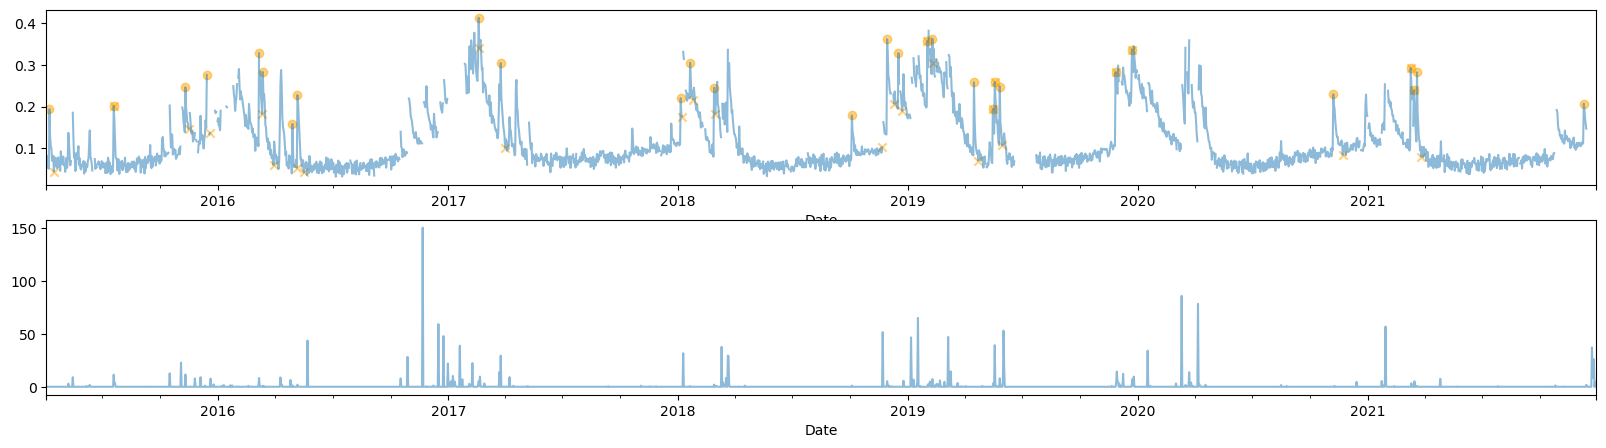

In [569]:
fig, (ax11, ax12) = plt.subplots(2,1, figsize=(20, 5))
ds_synced.soil_moisture_daily.plot(ax=ax11, alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax11.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
ds_synced.precip.plot(ax=ax12, alpha=0.5)
fig.savefig(os.path.join(output_path2, f'{target_station}_timeseries.png'))


(17532.0, 17895.0)

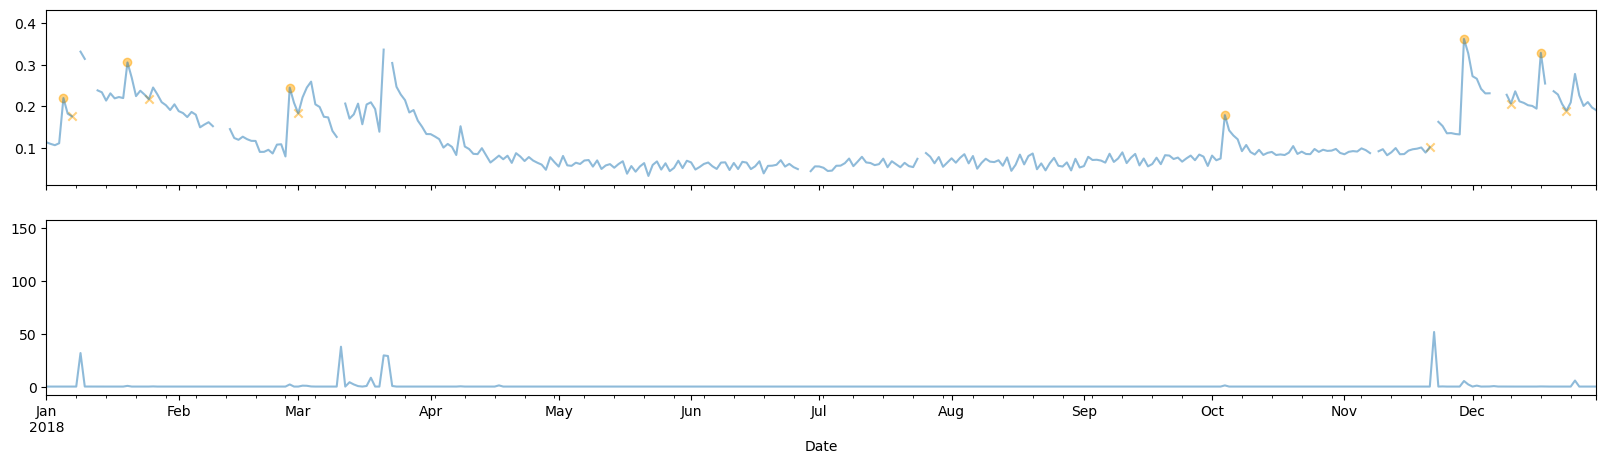

In [559]:
fig2, (ax21, ax22) = plt.subplots(2,1, figsize=(20, 5), sharex=True)
ds_synced.soil_moisture_daily.plot(ax=ax21, alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_start']].index, ds_synced.soil_moisture_daily[ds_synced['event_start']].values, color='orange', alpha=0.5)
ax21.scatter(ds_synced.soil_moisture_daily[ds_synced['event_end']].index, ds_synced.soil_moisture_daily[ds_synced['event_end']].values, color='orange', marker='x', alpha=0.5)
ds_synced.precip.plot(ax=ax22, alpha=0.5)
ax22.set_xlim([datetime(2018, 1, 1), datetime(2018, 12, 30)])

In [570]:
ds_synced['dSdt(t-1)'] = ds_synced.dSdt.shift(+1)
ds_synced.head(10)

,soil_moisture_daily,precip,PET,sm_for_dS_calc,dS,dt,dSdt,event_start,event_end,dSdt(t-1)
Date,,,,,,,,,,
2015-04-03,0.080593,0.0,4.26590,0.080593,NaN,1.0,-0.027751,False,False,NaN
2015-04-04,0.052842,0.0,4.10291,0.052842,-0.027751,1.0,0.020496,False,False,-0.027751
2015-04-05,0.073338,0.0,3.96359,0.073338,0.020496,1.0,0.008755,False,False,0.020496
2015-04-06,0.082093,0.0,3.65490,0.082093,0.008755,1.0,-0.031190,False,False,0.008755
2015-04-07,0.050903,0.0,2.23610,0.050903,-0.031190,1.0,0.142930,False,False,-0.031190
2015-04-08,0.193834,0.0,3.47952,0.193834,0.142930,1.0,-0.066909,True,False,0.142930
2015-04-09,0.126924,0.0,2.94221,0.126924,-0.066909,1.0,-0.021711,False,False,-0.066909
2015-04-10,0.105213,0.0,3.96109,0.105213,-0.021711,1.0,-0.004836,False,False,-0.021711
2015-04-11,0.100377,0.0,4.97817,0.100377,-0.004836,1.0,-0.030174,False,False,-0.004836


## Separate into events

In [571]:
start_indices = ds_synced[ds_synced['event_start']].index
end_indices = ds_synced[ds_synced['event_end']].index

# Create a new DataFrame with each row containing a list of soil moisture values between each pair of event_start and event_end
event_data = [{'event_start': start_index, 
               'event_end': end_index, 
               'soil_moisture_daily': list(ds_synced.loc[start_index:end_index, 'soil_moisture_daily'].values),
               'precip': list(ds_synced.loc[start_index:end_index, 'precip'].values),
               'PET': list(ds_synced.loc[start_index:end_index, 'PET'].values),
               'delta_theta': ds_synced.loc[start_index, 'dSdt(t-1)']
               } 
               for start_index, end_index in zip(start_indices, end_indices)]
event_df = pd.DataFrame(event_data)

,event_start,event_end,soil_moisture_daily,precip,PET,delta_theta
0,2015-04-08,2015-04-15,"[0.1938336, 0.1269245, 0.1052133, 0.1003775, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.47952, 2.94221, 3.96109, 4.97817, 4.31703, ...",0.142930
1,2015-07-19,2015-07-19,[0.2015915],[11.35296],[3.80034],0.144516
2,2015-11-10,2015-11-15,"[0.2465152, 0.1989249, 0.178879, 0.1621606, 0....","[11.55168, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.17364, 1.41344, 1.50433, 1.57533, 1.92462, ...",0.107632
3,2015-12-14,2015-12-19,"[0.2758582, nan, nan, nan, 0.1339117, 0.136489]","[0.02592, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.39289, 1.31537, 1.12303, 1.15161, 1.36111, ...",0.126664
4,2016-03-06,2016-03-11,"[0.3282443, nan, 0.2832519, 0.2276171, 0.20248...","[8.303040000000001, 0.0, 0.19872, 0.0, 0.0, 0.0]","[2.44018, 1.668, 2.43951, 2.70936, 3.38876, 1....",0.223324
5,2016-03-12,2016-03-29,"[0.2832137, 0.2196951, 0.2306282, 0.208455, 0....","[0.93312, 0.0, 0.52704, 0.0, 0.0, 0.0, 0.0, 0....","[1.9586, 1.67819, 2.50363, 2.854, 3.11875, 3.5...",0.101425
6,2016-04-28,2016-05-05,"[0.1584084, 0.0947883, 0.0556612, nan, nan, 0....","[1.296, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[4.37069, 4.76817, 5.09533, 4.72832, 5.0143, 4...",0.118810
7,2016-05-06,2016-05-16,"[0.2276094, 0.2096815, 0.1747873, 0.137013, 0....","[1.96992, 0.2592, 0.14688, 0.0, 0.0, 0.0, 0.0,...","[2.79902, 2.82999, 2.80917, 4.61278, 4.77115, ...",0.174474
8,2017-02-18,2017-02-19,"[0.4135987, 0.3398614]","[5.2272, 0.93312]","[1.60614, 1.24938]",0.103988
9,2017-03-25,2017-04-01,"[0.3045551, 0.22211, 0.1986549, 0.1748025, 0.1...","[29.38464, 0.00864, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.91731, 1.94767, 3.79821, 3.64859, 3.94047, ...",0.088266


In [599]:
event_df_long = event_df[event_df['soil_moisture_daily'].apply(lambda x: pd.notna(x).sum()) >= 4].copy()
event_df_long = event_df_long.reset_index(drop=True)
event_df_long


,event_start,event_end,soil_moisture_daily,precip,PET,delta_theta
0,2015-04-08,2015-04-15,"[0.1938336, 0.1269245, 0.1052133, 0.1003775, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.47952, 2.94221, 3.96109, 4.97817, 4.31703, ...",0.142930
1,2015-11-10,2015-11-15,"[0.2465152, 0.1989249, 0.178879, 0.1621606, 0....","[11.55168, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.17364, 1.41344, 1.50433, 1.57533, 1.92462, ...",0.107632
2,2016-03-06,2016-03-11,"[0.3282443, nan, 0.2832519, 0.2276171, 0.20248...","[8.303040000000001, 0.0, 0.19872, 0.0, 0.0, 0.0]","[2.44018, 1.668, 2.43951, 2.70936, 3.38876, 1....",0.223324
3,2016-03-12,2016-03-29,"[0.2832137, 0.2196951, 0.2306282, 0.208455, 0....","[0.93312, 0.0, 0.52704, 0.0, 0.0, 0.0, 0.0, 0....","[1.9586, 1.67819, 2.50363, 2.854, 3.11875, 3.5...",0.101425
4,2016-04-28,2016-05-05,"[0.1584084, 0.0947883, 0.0556612, nan, nan, 0....","[1.296, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[4.37069, 4.76817, 5.09533, 4.72832, 5.0143, 4...",0.118810
5,2016-05-06,2016-05-16,"[0.2276094, 0.2096815, 0.1747873, 0.137013, 0....","[1.96992, 0.2592, 0.14688, 0.0, 0.0, 0.0, 0.0,...","[2.79902, 2.82999, 2.80917, 4.61278, 4.77115, ...",0.174474
6,2017-03-25,2017-04-01,"[0.3045551, 0.22211, 0.1986549, 0.1748025, 0.1...","[29.38464, 0.00864, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.91731, 1.94767, 3.79821, 3.64859, 3.94047, ...",0.088266
7,2018-01-20,2018-01-25,"[0.3055856, 0.2688716, 0.2247538, 0.2376815, 0...","[0.65664, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.51822, 1.34713, 1.37457, 1.33409, 1.88341, ...",0.085544
8,2018-10-04,2018-11-21,"[0.1790778, 0.1424991, 0.1302097, 0.1210738, 0...","[1.09728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[2.23499, 2.88456, 3.53741, 3.5377, 3.03666, 3...",0.104093
9,2018-11-29,2018-12-10,"[0.3619635, 0.3272786, 0.2726644, 0.2664706, 0...","[5.24448, 1.9958399999999998, 0.0, 0.889919999...","[1.11729, 1.3339, 0.78794, 0.86198, 1.0994, 1....",0.229207


## Calculate tau

In [600]:
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import minimize

In [601]:
# Function for exponential model
def exp_model(t, delta_theta, theta_w, tau):
    return delta_theta * np.exp(-t/tau) + theta_w

def neg_log_likelihood(params, t, y):
    delta_theta, theta_w, tau, sigma = params
    y_hat = exp_model(t, delta_theta, theta_w, tau)
    residuals = y - y_hat
    ssr = np.sum(residuals ** 2)
    n = len(y)
    sigma2 = ssr / n
    ll = -(n / 2) * np.log(2 * np.pi * sigma2) - (1 / (2 * sigma2)) * ssr
    return -ll


In [602]:
min_sm_values_at_the_pt = df_ts_sync.soil_moisture_smapL3.min()
min_sm_values_at_the_pt

0.0315609

In [603]:
# Fit exponential model to each drydown event

opt_model = 'OLSE'
# opt_model = 'MLE'
drydown_params = []
for index, row in event_df_long.iterrows():
    start_date = row['event_start']
    end_date = row['event_end']
    delta_theta = row['delta_theta']
    soil_moisture_subset = np.asarray(row['soil_moisture_daily'])
    t = np.arange(0, len(soil_moisture_subset),1)
    soil_moisture_range = np.nanmax(soil_moisture_subset) - np.nanmin(soil_moisture_subset)
    soil_moisture_subset_min = np.nanmin(soil_moisture_subset)
    soil_moisture_subset_max = np.nanmax(soil_moisture_subset)
    x = t[~np.isnan(soil_moisture_subset)]
    y = soil_moisture_subset[~np.isnan(soil_moisture_subset)]
    #       delta_theta, theta_w, tau, sigma
    
    if opt_model == "MLE":
        bounds  = ((0, 2*soil_moisture_range), (min_sm_values_at_the_pt, soil_moisture_subset_min), (0, np.inf), (0, np.inf))
        p0      = [0.5*soil_moisture_subset_max, 2*soil_moisture_subset_min, 1, 0.1]
        res = minimize(neg_log_likelihood, p0, args=(t[~np.isnan(soil_moisture_subset)], soil_moisture_subset[~np.isnan(soil_moisture_subset)]), bounds=bounds, method='L-BFGS-B')
        popt = res.x
        if res.success and res.fun < 0:
            drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2]})
    elif opt_model == 'OLSE':
        # exp_model(t, delta_theta, theta_w, tau):
        bounds  = [(0, min_sm_values_at_the_pt, 0), (2*soil_moisture_range, soil_moisture_subset_min, np.inf)]
        p0      = [0.5*soil_moisture_range, (soil_moisture_subset_min+min_sm_values_at_the_pt)/2, 1]
        try: 
            popt, pcov = curve_fit(f=exp_model, xdata=x, ydata=y, p0=p0, bounds=bounds)
            # popt: Optimal values for the parameters so that the sum of the squared residuals of f(xdata, *popt) - ydata is minimized
            # pcov: The estimated covariance of popt
            y_opt = exp_model(x, *popt)
            residuals = y - y_opt
            ss_res = np.sum(residuals ** 2)
            ss_tot = np.sum((y - np.nanmean(y)) ** 2)
            r_squared = 1 - (ss_res / ss_tot)

            drydown_params.append({'event_start': start_date, 'event_end': end_date, 'delta_theta': popt[0], 'theta_w': popt[1], 'tau': popt[2], 'r_squared': r_squared, 'opt_drydown': y_opt.tolist()})
        except:
            print('Error raised')
            continue

# Convert drydown parameters to DataFrame
drydown_params_df = pd.DataFrame(drydown_params)
drydown_params
# # Only retain drydown events with R2 >= 0.7
# r_squared_threshold = 0.7
# drydown_events_r2 = []
# for index, row in drydown_params_df.iterrows():
#     start_date = row['start_date']
#     end_date = row['end_date']
#     soil_moisture_subset = soil_moisture_daily[start_date:end_date]
#     x = (soil_moisture_subset.index - start_date).days
#     y = soil_moisture_subset['soil_moisture']
#     popt, pcov = curve_fit(exp_model, x, y, p0=[row['delta_theta'], row['theta_w'], row['tau']])
#     residuals = y - exp_model(x, *popt)
#     ss_res = np.sum(res


[{'event_start': Timestamp('2015-04-08 00:00:00'),
  'event_end': Timestamp('2015-04-15 00:00:00'),
  'delta_theta': 0.14032726129333073,
  'theta_w': 0.043794599999999996,
  'tau': 2.790355423048749,
  'r_squared': 0.9207302368565375,
  'opt_drydown': [0.18412186129333072,
   0.14185660578008907,
   0.1123212489845708,
   0.09168166475763374,
   0.0772585298007718,
   0.06717950787394665,
   0.0601361928591973,
   0.05521425829479656]},
 {'event_start': Timestamp('2015-11-10 00:00:00'),
  'event_end': Timestamp('2015-11-15 00:00:00'),
  'delta_theta': 0.10032701922409337,
  'theta_w': 0.14534897109514813,
  'tau': 1.7318059750675934,
  'r_squared': 0.9922027772633317,
  'opt_drydown': [0.2456759903192415,
   0.20166634886142035,
   0.1769620605998281,
   0.16309460250892868,
   0.15531027001302633,
   0.15094062764529292]},
 {'event_start': Timestamp('2016-03-06 00:00:00'),
  'event_end': Timestamp('2016-03-11 00:00:00'),
  'delta_theta': 0.29291139999999993,
  'theta_w': 0.0419669831

In [604]:
event_df_with_curvefit = pd.merge(event_df_long, drydown_params_df.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
event_df_with_curvefit

,event_start,event_end,soil_moisture_daily,precip,PET,delta_theta,theta_w,tau,r_squared,opt_drydown
0,2015-04-08,2015-04-15,"[0.1938336, 0.1269245, 0.1052133, 0.1003775, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[3.47952, 2.94221, 3.96109, 4.97817, 4.31703, ...",0.142930,0.043795,2.790355,0.920730,"[0.18412186129333072, 0.14185660578008907, 0.1..."
1,2015-11-10,2015-11-15,"[0.2465152, 0.1989249, 0.178879, 0.1621606, 0....","[11.55168, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.17364, 1.41344, 1.50433, 1.57533, 1.92462, ...",0.107632,0.145349,1.731806,0.992203,"[0.2456759903192415, 0.20166634886142035, 0.17..."
2,2016-03-06,2016-03-11,"[0.3282443, nan, 0.2832519, 0.2276171, 0.20248...","[8.303040000000001, 0.0, 0.19872, 0.0, 0.0, 0.0]","[2.44018, 1.668, 2.43951, 2.70936, 3.38876, 1....",0.223324,0.041967,7.018691,0.961701,"[0.3348783831209105, 0.2622507955542884, 0.232..."
3,2016-03-12,2016-03-29,"[0.2832137, 0.2196951, 0.2306282, 0.208455, 0....","[0.93312, 0.0, 0.52704, 0.0, 0.0, 0.0, 0.0, 0....","[1.9586, 1.67819, 2.50363, 2.854, 3.11875, 3.5...",0.101425,0.059474,5.979991,0.959894,"[0.2754369736054637, 0.2421808689961992, 0.214..."
4,2016-04-28,2016-05-05,"[0.1584084, 0.0947883, 0.0556612, nan, nan, 0....","[1.296, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[4.37069, 4.76817, 5.09533, 4.72832, 5.0143, 4...",0.118810,0.053136,0.920828,0.940103,"[0.15931683672951874, 0.08897945003483307, 0.0..."
5,2016-05-06,2016-05-16,"[0.2276094, 0.2096815, 0.1747873, 0.137013, 0....","[1.96992, 0.2592, 0.14688, 0.0, 0.0, 0.0, 0.0,...","[2.79902, 2.82999, 2.80917, 4.61278, 4.77115, ...",0.174474,0.031561,3.995260,0.961178,"[0.24218759327956513, 0.1955484831187997, 0.15..."
6,2017-03-25,2017-04-01,"[0.3045551, 0.22211, 0.1986549, 0.1748025, 0.1...","[29.38464, 0.00864, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.91731, 1.94767, 3.79821, 3.64859, 3.94047, ...",0.088266,0.096700,3.028108,0.972568,"[0.2955845894298791, 0.23964878936370537, 0.19..."
7,2018-01-20,2018-01-25,"[0.3055856, 0.2688716, 0.2247538, 0.2376815, 0...","[0.65664, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.51822, 1.34713, 1.37457, 1.33409, 1.88341, ...",0.085544,0.217109,1.466277,0.931075,"[0.30645724616853826, 0.262284072198538, 0.239..."
8,2018-10-04,2018-11-21,"[0.1790778, 0.1424991, 0.1302097, 0.1210738, 0...","[1.09728, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[2.23499, 2.88456, 3.53741, 3.5377, 3.03666, 3...",0.104093,0.082827,2.815291,0.646334,"[0.17609133466415083, 0.14820810356937897, 0.1..."
9,2018-11-29,2018-12-10,"[0.3619635, 0.3272786, 0.2726644, 0.2664706, 0...","[5.24448, 1.9958399999999998, 0.0, 0.889919999...","[1.11729, 1.3339, 0.78794, 0.86198, 1.0994, 1....",0.229207,0.206930,3.364539,0.852722,"[0.3573321417655402, 0.3186611275601651, 0.289..."


## Plot

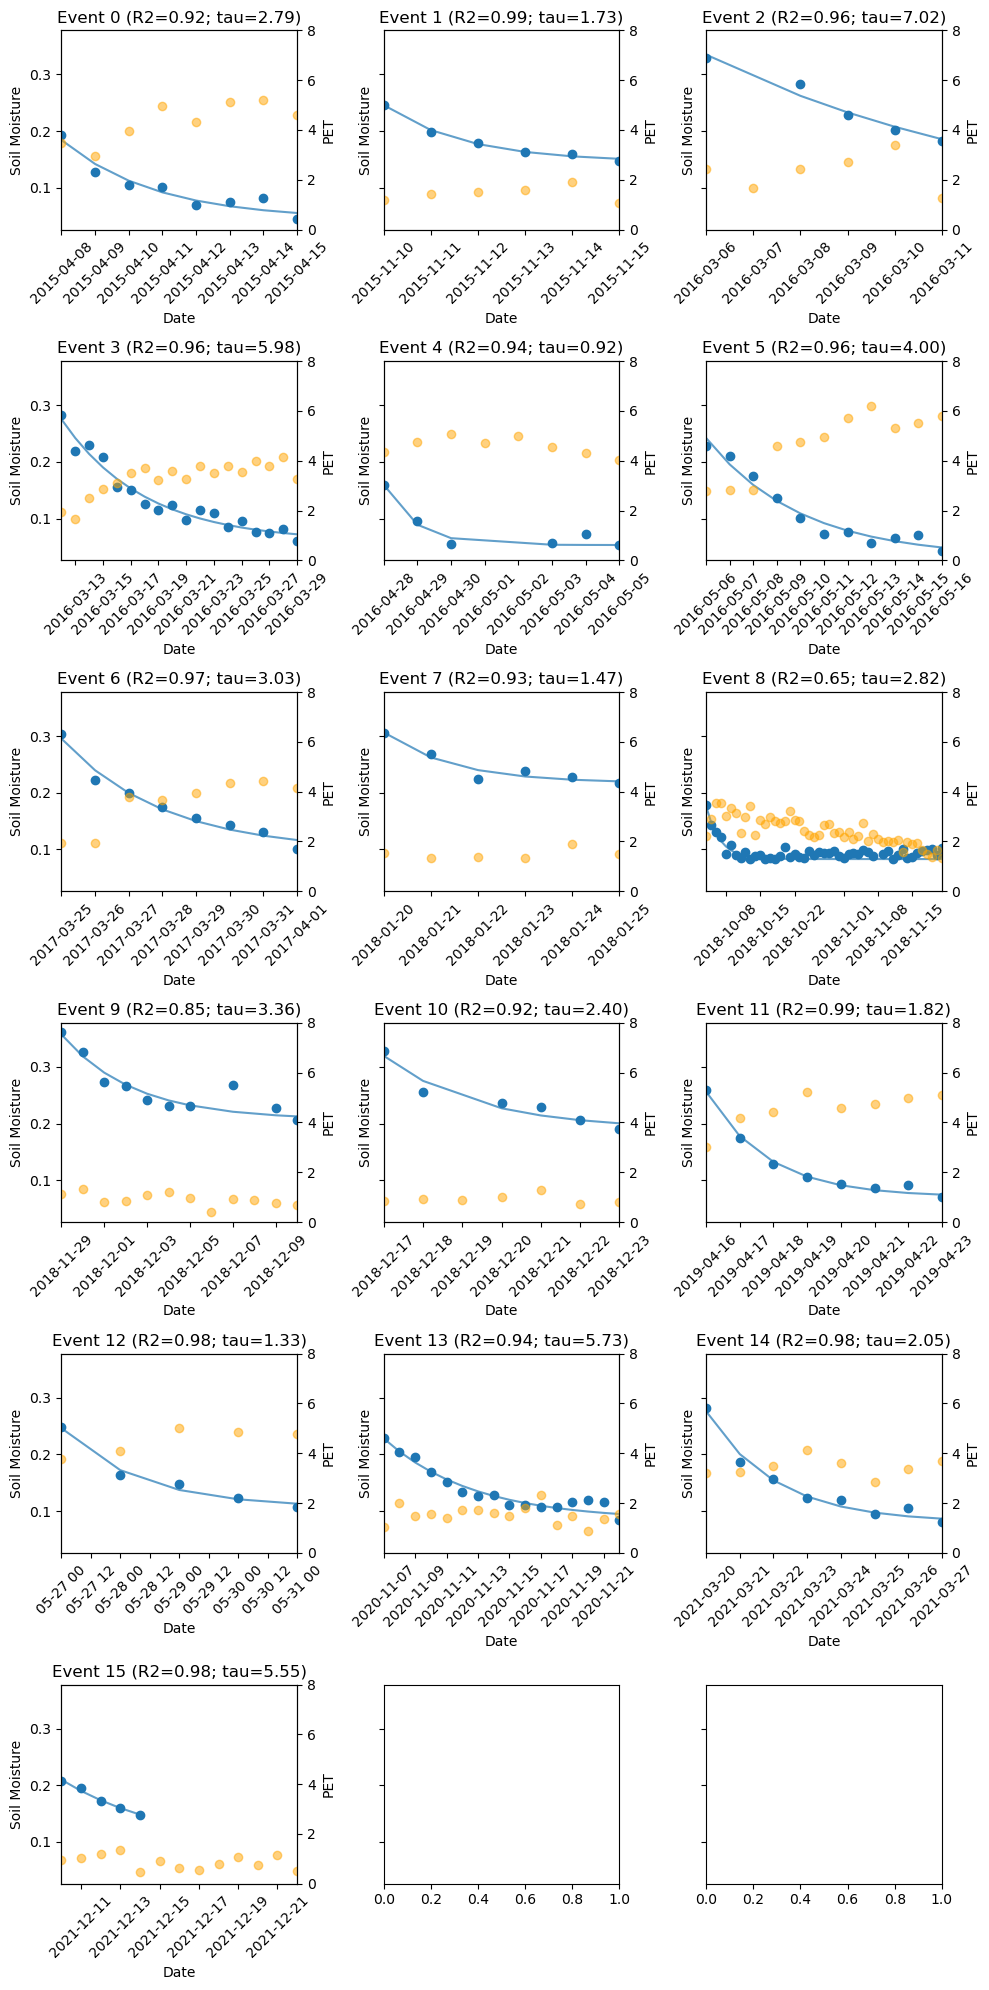

In [597]:
# Convert the event start/end columns to datetime format
event_df_with_curvefit['event_start'] = pd.to_datetime(event_df_long['event_start'])
event_df_with_curvefit['event_end'] = pd.to_datetime(event_df_long['event_end'])

# Determine the number of columns needed for the subplots grid
num_events = len(event_df_with_curvefit)
num_cols = 3
num_rows = int(num_events / num_cols) + int(num_events % num_cols != 0)

# Plot each row of the event DataFrame as a time series
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharey=True, figsize=(10, 20))
for index, row in event_df_with_curvefit.iterrows():

    x = pd.date_range(start=row['event_start'], end=row['event_end'], freq='D')
    y = np.asarray(row['soil_moisture_daily'])
    y_opt = np.asarray(row['opt_drydown'])
    y2 = row['PET']
    t = np.arange(0, len(row['soil_moisture_daily']),1)
    r_squared = row['r_squared']
    tau = row['tau']

    ax_row = int(index / num_cols)
    ax_col = index % num_cols
    axes[ax_row, ax_col].scatter(x, y)
    axes[ax_row, ax_col].plot(x[~np.isnan(y)], y_opt, alpha=.7)
    ax2 = axes[ax_row, ax_col].twinx()
    ax2.scatter(x, y2, color='orange', alpha=.5)
    axes[ax_row, ax_col].set_title(f'Event {index} (R2={r_squared:.2f}; tau={tau:.2f})')
    axes[ax_row, ax_col].set_xlabel('Date')
    axes[ax_row, ax_col].set_ylabel('Soil Moisture')
    axes[ax_row, ax_col].set_xlim([row['event_start'], row['event_end']])
    ax2.set_ylim([0, 8])
    ax2.set_ylabel('PET')
    # Rotate the x tick labels
    axes[ax_row, ax_col].tick_params(axis='x', rotation=45)

fig.tight_layout()
fig.show()
fig.savefig(os.path.join(output_path2, f'{target_station}_events.png'))


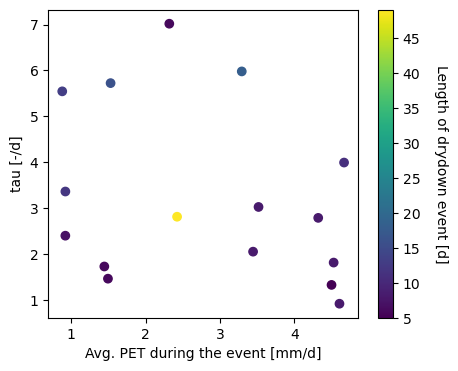

In [606]:
event_df_with_curvefit['mean_PET'] = event_df_with_curvefit['PET'].apply(np.mean)
event_df_with_curvefit['event_length'] = event_df_with_curvefit['PET'].apply(len)
fig, ax = plt.subplots(1,1, figsize=(5, 4))
sc = ax.scatter(event_df_with_curvefit['mean_PET'], event_df_with_curvefit['tau'], c=event_df_with_curvefit['event_length'])
ax.set_xlabel('Avg. PET during the event [mm/d]')
ax.set_ylabel('tau [-/d]')
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('Length of drydown event [d]', rotation=270, labelpad=20)
fig.savefig(os.path.join(output_path2, f'{target_station}_tau_vs_PET.png'))

## A figure for bad signature paper|

In [ ]:
event_df_with_curvefit['mean_SM'] = event_df_with_curvefit['soil_moisture_daily'].apply(np.mean)
# event_df_with_curvefit['event_length'] = event_df_with_curvefit['PET'].apply(len)
fig, ax = plt.subplots(1,1, figsize=(5, 4))
sc = ax.scatter(event_df_with_curvefit['mean_SM'], event_df_with_curvefit['tau'], c=event_df_with_curvefit['event_length'])
ax.set_xlabel('Avg. SM during the event [m3/m3]')
ax.set_ylabel('tau [-/d]')
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('Length of drydown event [d]', rotation=270, labelpad=20)

In [ ]:


fig, ax = plt.subplots(1,1, figsize=(5, 4))
sc = ax.scatter(event_df_with_curvefit['event_length'], event_df_with_curvefit['tau'])
ax.set_xlabel('event_length [d]')
ax.set_ylabel('tau [-/d]')
# cbar = fig.colorbar(sc)
# cbar.ax.set_ylabel('Length of drydown event [d]', rotation=270, labelpad=20)



In [ ]:


event_df_with_curvefit['mean_PET'] = event_df_with_curvefit['PET'].apply(np.mean)
event_df_with_curvefit['event_length'] = event_df_with_curvefit['PET'].apply(len)
fig, ax = plt.subplots(1,1, figsize=(5, 4))
select_idx = event_df_with_curvefit.r_squared > 0.7
sc = ax.scatter(event_df_with_curvefit['mean_PET'][select_idx], event_df_with_curvefit['tau'][select_idx], c=event_df_with_curvefit['event_length'][select_idx])
ax.set_xlabel('Avg. PET during the event [mm/d]')
ax.set_ylabel('tau [-/d]')
cbar = fig.colorbar(sc)
cbar.ax.set_ylabel('Length of drydown event [d]', rotation=270, labelpad=20)



ValueError: x and y must be the same size

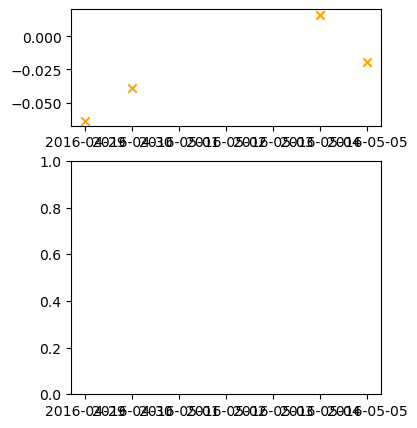

In [607]:
# Convert the event start/end columns to datetime format
event_df_with_curvefit['event_start'] = pd.to_datetime(event_df_long['event_start'])
event_df_with_curvefit['event_end'] = pd.to_datetime(event_df_long['event_end'])

# Determine the number of columns needed for the subplots grid
num_events = len(event_df_with_curvefit)
num_cols = 3
num_rows = int(num_events / num_cols) + int(num_events % num_cols != 0)

import matplotlib.gridspec as gridspec

# Plot each row of the event DataFrame as a time series
fig = plt.figure(figsize=(4, 5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])  # create a 2x1 grid with the lower subplot double the height

# create the subplots
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

index = 4
row = event_df_with_curvefit.iloc[index]

x = pd.date_range(start=row['event_start'], end=row['event_end'], freq='D')
y = np.asarray(row['soil_moisture_daily'])
y_opt = np.asarray(row['opt_drydown'])
y2 = np.diff(y)
y2 = np.insert(y2, 0, np.nan)
y3 = np.diff(y_opt)
y3 = np.insert(y_opt, 0, np.nan)

t = np.arange(0, len(row['soil_moisture_daily']),1)
r_squared = row['r_squared']
tau = row['tau']

ax1.scatter(x, y2, color='orange', marker='x')
ax1.scatter(x, y3, color='red', marker='x')
ax2.scatter(x, y, label='SMAP observation')
ax2.plot(x[~np.isnan(y)], y_opt, alpha=.7, label='Exponential model')
ax1.set_title(f'An example drydown event')
ax2.set_xlabel('Date')
ax2.set_ylabel(r'Volumetric soil moisture content, $\theta$ [m3/m3]')
ax1.set_ylabel(r'd$\theta$/dt')
ax2.set_xlim([row['event_start'], row['event_end']])
ax2.legend()

# ax1.set_xlabel([])  # hide the x-axis ticks

# Rotate the x tick labels
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
